### Multivariate DCC-GARCH Model notation

$a_t = H_t^{1/2} z_t$ 

$\{z_t\}$ : n × 1 vector of iid errors such that $\mathbb{E}[z_t] = 0$ and $\mathbb{E}[z_tz^T_t] = I$

$H_t$ : conditional variance matrix

$H_t = D_tR_tD_t$

$D_t = diag(h_{i,t}, \cdots, h_{n,t})$

$h_{i,t} = \alpha_{i,0} + \alpha_{i,1}a^2_{t-1} + \beta_{i,1}h_{i,t-1}$

$R_t = Q^{*-1}\overline{Q}Q^{*-1}$

$Q_t = (1-a-b)\overline Q + a\epsilon_{t-1}\epsilon_{t-1}^T + bQ_{t-1}$

$\epsilon_t \sim \mathcal{N}(0,R_t)$

### paper notation

$\Sigma_{t+\Delta t} = (ACC^*+CC^* A^*)\Delta t +e^{-A\Delta t}\Sigma_te^{-A^*\Delta t}+B(\overline{Z}-Z_t)(\overline{Z}-Z_t)^*B^*\Delta t$

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# 100 assets
num_assets = 100
num_rows_per_asset = 5


# import from R
Q_bar = pd.read_csv('Q_bar.csv').drop('Unnamed: 0',axis=1).to_numpy()
coef = pd.read_csv('coef.csv')

# mu, ar1, omega, alpha, beta 0,1,2,3,4 for each asset - 5 values for each asset so 500 total values
alpha = np.array([coef.loc[i,'x'] for i in range(3,(num_assets*num_rows_per_asset),5)])
beta = np.array([coef.loc[i,'x'] for i in range(4,(num_assets*num_rows_per_asset),5)])
omega = np.array([coef.loc[i,'x'] for i in range(2,(num_assets*num_rows_per_asset),5)])

# calculated in R
a = 0.001614868
b = 0.518722861

# should be 100
print(len(omega))

100


In [95]:
T = 100

# initialize
a0 = np.random.multivariate_normal(np.zeros(100),0.01*np.identity(100))

# needed to ensure H psd
h0 = np.ones(100)
Q = pd.read_csv('Q_init.csv').drop('Unnamed: 0',axis=1).to_numpy()
H_list = []
a_list = []

for t in range(T):
    # compute R_t
    Q_star_inv = np.linalg.inv(np.diag(Q.diagonal()))

    R = Q_star_inv@Q_bar@Q_star_inv

    # compute D_t
    h1 = omega + alpha*a0**2 + beta*h0
    D = np.power(np.diag(h1),1/2)
    
    # compute H
    H = D@R@D

    # draw z
    z = np.random.randn(100,1)

    # compute a: a = 𝐻^1/2 @ z
    a1 = np.linalg.cholesky(H)@z
    
    # draw e
    e = np.random.multivariate_normal(np.zeros(100),R)
    
    # step Q
    Q = (1-a-b)*Q_bar + a*np.outer(e,e) + b*Q
    
    # step a,h
    h0 = h1
    a0 = a1.squeeze()
    a_plot.append(a0)
    
    # covariance matrices - keep track of our generated data
    H_list.append(H)
    # returns
    a_list.append(a0)

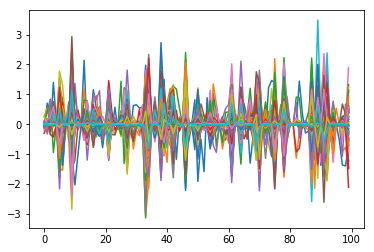

In [96]:
for i in range(len(a_plot)):
    plt.plot(a_plot[i])

In [104]:
T = 1000

# this will be returned
generated_data = {}


condNum_list = []
a_list = []


# initialize
a0 = np.random.multivariate_normal(np.zeros(100),0.01*np.identity(100))

# needed to ensure H psd
h0 = np.ones(100)


for t in range(T):
    # compute R_t
    Q_star_inv = np.linalg.inv(np.diag(Q.diagonal()))

    R = Q_star_inv@Q_bar@Q_star_inv

    # compute D_t
    h1 = omega + alpha*a0**2 + beta*h0
    D = np.power(np.diag(h1),1/2)

    # compute H
    H = D@R@D

    # draw z
    z = np.random.randn(100,1)

    # compute a: a = 𝐻^1/2 @ z
    a1 = np.linalg.cholesky(H)@z

    # draw e
    e = np.random.multivariate_normal(np.zeros(100),R)

    # step Q
    Q = (1-a-b)*Q_bar + a*np.outer(e,e) + b*Q

    # step a,h
    h0 = h1
    a0 = a1.squeeze()
    a_plot.append(a0)

    # covariance matrices - keep track of our generated data
    condNum_list.append(np.linalg.cond(H))
    # returns
    a_list.append(a0)

generated_data['condition_nums'] = condNum_list
generated_data['return_vecs'] = a_list

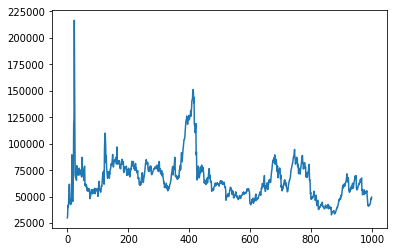

In [105]:
plt.plot(generated_data['condition_nums'])

In [125]:
# 10 assets
num_assets = 10
num_rows_per_asset = 5

# calculated in R
a = 0.007073296
b = 0.658588119

# import from R
Q_bar = pd.read_csv('Q_bar.csv').drop('Unnamed: 0',axis=1).to_numpy()
coef = pd.read_csv('coef.csv')
H_init = pd.read_csv('H_init.csv').drop('Unnamed: 0',axis=1).to_numpy()

# mu, ar1, omega, alpha, beta 0,1,2,3,4 for each asset - 5 values for each asset so 500 total values
alpha = np.array([coef.loc[i,'x'] for i in range(3,(num_assets*num_rows_per_asset),5)])
beta = np.array([coef.loc[i,'x'] for i in range(4,(num_assets*num_rows_per_asset),5)])
omega = np.array([coef.loc[i,'x'] for i in range(2,(num_assets*num_rows_per_asset),5)])

In [218]:
# hyper-params
T = 1000
e = 1e-5

# this will be returned
generated_data = {}

condNum_list = []
a_list = []
H_list = []

# initialize
a0 = np.linalg.cholesky(H_init)@np.random.multivariate_normal(np.zeros(num_assets),0.01*np.identity(num_assets))

# needed to ensure H psd
h0 = np.ones(num_assets)*e
Q = pd.read_csv('Q_init.csv').drop('Unnamed: 0',axis=1).to_numpy()

for t in range(T):
    # compute R_t
    Q_star_inv = np.linalg.inv(np.diag(Q.diagonal()))

    R = Q_star_inv@Q_bar@Q_star_inv

    # compute D_t
    h1 = omega + alpha*a0**2 + beta*h0
    D = np.power(np.diag(h1),1/2)
    
    # compute H
    H = D@R@D

    # draw z
    z = np.random.multivariate_normal(np.zeros(num_assets),1*np.identity(num_assets))

    # compute a: a = 𝐻^1/2 @ z
    a1 = np.linalg.cholesky(H)@z
    
    # draw e
    e = np.random.multivariate_normal(np.zeros(num_assets),R)
    
    # step Q
    Q = (1-a-b)*Q_bar + a*np.outer(e,e) + b*Q
    
    # step a,h
    h0 = h1
    a0 = a1.squeeze()
    
    # covariance matrices - keep track of our generated data
    condNum_list.append(np.linalg.cond(H))
    H_list.append(H)
    # returns
    a_list.append(a0)
    
generated_data['condition_nums'] = condNum_list
generated_data['return_vecs'] = a_list

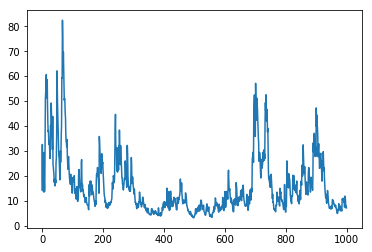

In [219]:
plt.plot(generated_data['condition_nums'])

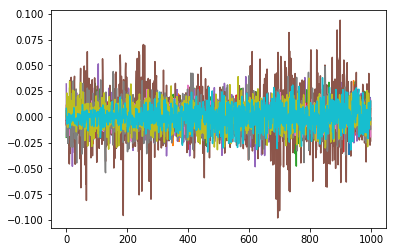

In [229]:
for j in range(10):
    plt.plot([a_list[i][j] for i in range(1000)])